In [1]:
# hide tensorflow warnings on GPU execution (we will use CPU)
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# disable GPU usage
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import cirq, random, sympy
import tensorflow_quantum as tfq
import tensorflow as tf
from cirq.contrib.svg import SVGCircuit
from cirq.circuits import InsertStrategy

# limit GPU memory growth to avoid OUT_OF_MEMORY issues (before initializing GPU -- if used)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [21]:
class qGAN(tf.keras.Model):
    
    def __init__(self, num_epochs, batch_size, window_length, n_critic, gp, num_layers, num_qubits):
        super(qGAN, self).__init__()
        
        # classical hyperparameters
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.window_length = window_length
        self.n_critic = n_critic
        self.gp = gp
        
        # quantum hyperparameters
        # one layer corresponds to a rotation and an entangling layer together
        self.num_layers = num_layers
        self.num_qubits = num_qubits
        
        # quantum circuit settings
        self.qubits = cirq.GridQubit.rect(1, num_qubits)
        # create the set of Pauli strings to measure -> {X1, Z1, X2, Z2, etc}
        # X1 means we measure the first qubit only with X, Z1 the first qubit only with Z and so on...
        self.measurements = []
        for qubit in self.qubits:
            self.measurements.append(cirq.X(qubit))
            self.measurements.append(cirq.Z(qubit))
            
        # number of parameters of the PQC and re-uploading layers
        self.num_params = self.count_params()
        
        # define the trainable parameters of the PQC main and re-uploading layers (trainable)
        self.params_pqc = [sympy.Symbol(f'theta{i}') for i in range(self.num_params)]
        
    ####################################################################################
    #
    # count the parameters of the quantum circuit
    #
    ####################################################################################
    def count_params(self):
        
        # rotation layer with Rx, Ry, Rz has 3N parameters, where N is the number of qubits
        # the entangling layer is not parameterized
        num_params_pqc = 3*self.num_qubits*self.num_layers
        
        # also, count the parameters of the re-uploading layer that is sandwiched between rotation-entangling layers
        # there is one re-uploading layer after each rotation-entangling layer with a parameterized Rx gate,
        # so the number of parameters is equal to the number of qubits for each re-uploading layer
        num_params_upload = self.num_layers*self.num_qubits
        # count the parameters of the entangling layers with Star topology
        num_params_pqc += self.num_layers*(self.num_qubits-1)
        
        # the last layer of the PQC is a rotation layer
        num_params_pqc += 3*self.num_qubits
                    
        return num_params_pqc+num_params_upload
    
    ####################################################################################
    #
    # the encoding layer: resolve the parameters by uniform noise values,
    # used to prepare the initial state for the generator circuit
    #
    ####################################################################################
    def encoding_layer(self, noise_params):
        
        return cirq.Circuit(cirq.Rx(rads=noise_params[i])(self.qubits[i]) for i in range(self.num_qubits))
        
    ####################################################################################
    #
    # the quantum generator as a PQC with Ring topology for the entangling layer
    #
    #################################################################################### 
    def define_generator_circuit(self):
        
        # cirq circuit 
        pqc = cirq.Circuit()
        
        # index for the parameter tensor of the PQC main and re-uploading layers
        idx = 0
        
        for layer in range(self.num_layers):
            ###############################################################
            #
            # single-qubit rotation layer
            #
            ###############################################################
            for qubit in self.qubits:
                pqc.append(cirq.Rx(rads=self.params_pqc[idx])(qubit))
                idx += 1
                pqc.append(cirq.Ry(rads=self.params_pqc[idx])(qubit))
                idx += 1
                pqc.append(cirq.Rz(rads=self.params_pqc[idx])(qubit))
                idx += 1
            
             ###############################################################
            #
            # entangling layer (parameterized)
            #
            ###############################################################
            for qubit in range(1, self.num_qubits):
                pqc.append(cirq.ms(self.params_pqc[idx]).on(self.qubits[0], self.qubits[qubit]), strategy=InsertStrategy.NEW)
                idx +=1
            
            ###############################################################
            #
            # re-uploading layer with Rx rotation
            # (set the strategy for better readability and understanding)
            #
            ###############################################################
            for i, qubit in enumerate(self.qubits):
                if i == 0:
                    pqc.append(cirq.Rx(rads=self.params_pqc[idx])(qubit), strategy=InsertStrategy.NEW)
                else:
                    pqc.append(cirq.Rx(rads=self.params_pqc[idx])(qubit), strategy=InsertStrategy.INLINE)
                idx += 1
                
        #####################################################################
        #
        # single-qubit rotation layer as the last layer before measurement
        #
        #####################################################################
        for qubit in self.qubits:
                pqc.append(cirq.Rx(rads=self.params_pqc[idx])(qubit))
                idx += 1
                pqc.append(cirq.Ry(rads=self.params_pqc[idx])(qubit))
                idx += 1
                pqc.append(cirq.Rz(rads=self.params_pqc[idx])(qubit))
                idx += 1 
        
        return pqc

In [22]:
##################################################################
#
# Hyperparameters
#
##################################################################
WINDOW_LENGTH = 20  # this must be equal to the number of Pauli strings to measure
NUM_QUBITS = 4  # number of qubits
NUM_LAYERS = 4  # number of layers for the PQC

# training hyperparameters
EPOCHS = 3000
BATCH_SIZE = 10

n_critic = 2 # number of iterations for the critic per epoch
LAMBDA = 10  # gradient penalty strength

# instantiate the QGAN model object
qgan = qGAN(EPOCHS, BATCH_SIZE, WINDOW_LENGTH, n_critic, LAMBDA, NUM_LAYERS, NUM_QUBITS)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


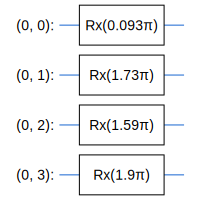

In [8]:
# display the noise encoding layer
# generate noise parameters for the encoding layer
noise_values = np.random.uniform(0, 2 * np.pi, size=NUM_QUBITS)
generator_input_state = qgan.encoding_layer(noise_values)
# convert to tensorflow quantum tensor
generator_input = tfq.convert_to_tensor([generator_input_state])
SVGCircuit(generator_input_state)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

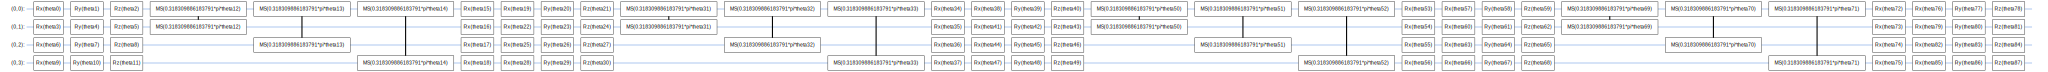

In [23]:
# display the generator circuit
SVGCircuit(qgan.define_generator_circuit())

In [32]:
def rolling_window(data, m, s):
    return tf.map_fn(lambda i: data[i:i+m], tf.range(0, len(data) - m + 1, s), dtype=tf.float64)

data = tf.constant([i for i in range(3777)], dtype=tf.float64)
print(data)

tf.Tensor([0.000e+00 1.000e+00 2.000e+00 ... 3.774e+03 3.775e+03 3.776e+03], shape=(3777,), dtype=float64)


In [33]:
print(tf.shape(rolling_window(data, 20, 5)))

tf.Tensor([752  20], shape=(2,), dtype=int32)


In [35]:
 def define_critic_model(window_length):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=10, strides=1, input_shape=(window_length, 1), padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=10, strides=1, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=10, strides=1, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
    
        model.add(tf.keras.layers.Flatten())
    
        model.add(tf.keras.layers.Dense(32, dtype=tf.float64))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
        model.add(tf.keras.layers.Dropout(0.2))
    
        model.add(tf.keras.layers.Dense(1, dtype=tf.float64))

        return model
    
define_critic_model(20).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 20, 64)            704       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 20, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 20, 128)           82048     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 20, 128)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 20, 128)           163968    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 128)           0         
                                                                 
 flatten_1 (Flatten)         (None, 2560)             